# Imports

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.losses import Loss
from tensorflow.keras.applications import VGG16
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import albumentations as A
import xml.etree.ElementTree as ET
import tensorflow as tf
import json
import numpy as np
import os
import math
import time
import cv2
import zipfile 

# Sorting the data

source: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

## Extracting zip file

In [3]:
file_name = "archive (3).zip"
zip_file = zipfile.ZipFile(file_name)
zip_file.extractall()

os.mkdir('data')
folders = ['train', 'test', 'valid']
for folder in folders:
    if not os.path.isdir(f'data/{folder}'):
        os.mkdir(f'data/{folder}')
        for cat in ['images', 'annotations']:
            os.mkdir(f'data/{folder}/{cat}')

## Dividing the data into 3 sets

In [4]:
number_of_images = len(os.listdir('images'))
train_images_num = math.floor(number_of_images * 0.7)
test_images_num = math.floor((number_of_images- train_images_num)*0.5)
valid_images_num = number_of_images-train_images_num-test_images_num

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    # if len(img.shape) > 2 and img.shape[2] == 4:
    img = img[:, :, :3]
    return img

In [6]:
images = tf.data.Dataset.list_files('images/*.png')

im = list(images.take(1))[0]

print(im)

images = images.map(load_image)

im = load_image(im)

tf.Tensor(b'images\\Cars64.png', shape=(), dtype=string)


In [7]:
for directory in ['images', 'annotations']:
    all_files = os.listdir(directory)
    for folder, num_images in [('train', train_images_num), ('test', test_images_num), ('valid', valid_images_num)]:
        for i in range(num_images):
            file_name = all_files.pop(0)
            existing_filepath = os.path.join(directory, file_name)
            new_filepath = os.path.join('data', folder, directory, file_name)
            os.replace(existing_filepath, new_filepath)
    os.rmdir(directory)

## XML to JSON

In [8]:
import json

for folder in folders:    
    path = os.path.join('data', folder, 'annotations')
    for file in os.listdir(path):
        obj = {'file': '', 'coords': [[]], 'width': 0, 'height': 0}
        tree = ET.parse(os.path.join('data', folder, 'annotations', file), parser=ET.XMLParser(encoding="utf-8"))
        root = tree.getroot()
        image_file = file.split('.')[0]+'.png'
        obj['file'] = image_file
        obj['height'], obj['width'] = int(root[2][1].text), int(root[2][0].text)
        for i in range(4):
            x = int(root[4][5][i].text)
            obj['coords'][0].append(x)
        with open(os.path.join(path, file.split('.')[0]+'.json'), 'w+') as f:
            f.write(json.dumps(obj))
        os.remove(os.path.join(path, file))

In [9]:
transform = A.Compose([
    A.RandomCrop(width=200, height=200), 
    A.RGBShift(p=0.2), 
    A.RandomGamma(p=0.2), 
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'], min_visibility=0.5))

In [10]:
img = cv2.imread(os.path.join('data','train', 'images','Cars0.png'))

with open(os.path.join('data', 'train', 'annotations', 'Cars0.json')) as file:
    json_file = json.load(file)
    coords = json_file['coords']
    height, width = json_file['height'], json_file['width']

In [11]:
coords

[[226, 125, 419, 173]]

In [12]:
coords = np.divide(coords, [width,height,width,height]).tolist()
# coords.append('licence_plate')
coords[0]

[0.452, 0.4664179104477612, 0.838, 0.6455223880597015]

In [13]:
transformed = transform(image=img, bboxes=[coords[0]], class_labels=['licence_plate'])

In [14]:
transformed['bboxes']

[(0.4, 0.27, 1.0, 0.51)]

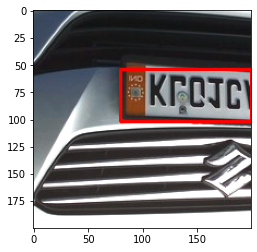

In [15]:
cv2.rectangle(transformed['image'], 
              tuple(np.multiply(transformed['bboxes'][0][:2], [200,200]).astype(int)),
              tuple(np.multiply(transformed['bboxes'][0][2:4], [200,200]).astype(int)), 
                    (255,0,0), 2)
plt.imshow(transformed['image'])


In [16]:
for folder in folders:
    images_path = os.path.join('data', folder, 'images')
    labels_path = os.path.join('data', folder, 'annotations')
    for file in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, file))

        with open(os.path.join(labels_path, file.split('.')[0]+".json")) as f:
            json_file = json.load(f)
            coords = json_file['coords'][0]
            height, width = json_file['height'], json_file['width']

        coords = list(np.divide(coords, [width,height,width,height]))
        
        for x in range(2):
            try: 
                transformed = transform(image=img, bboxes=[coords], class_labels=['licence_plate'])

                annotation = {}
                # annotation['image'] = img
                annotation['file'] = f'{file.split(".")[0]}.{x}.png'
                annotation['coords'] = np.multiply(transformed['bboxes'], [200, 200, 200, 200]).tolist()
                annotation['height'], annotation['width'] = 200, 200

            except Exception as e:
                print(e)
                continue

            cv2.imwrite(os.path.join(images_path, f'{file.split(".")[0]}.{x}.png'), transformed['image'])
            with open(os.path.join(labels_path, f'{file.split(".")[0]}.{x}.json'), 'w+') as f:
                f.write(json.dumps(annotation))

operands could not be broadcast together with shapes (0,) (4,) 
Requested crop size (200, 200) is larger than the image size (196, 400)
Requested crop size (200, 200) is larger than the image size (196, 400)
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
operands could not be broadcast together with shapes (0,) (4,) 
Requested crop size (200, 200) is larger than the image size (185, 400)
Requested crop size (200, 200) is larger than the image size (185, 400)
Requeste

In [17]:
train_images = tf.data.Dataset.list_files('data/train/images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (200,200)))
train_images = train_images.map(lambda x: x/255)


test_images = tf.data.Dataset.list_files('data/test/images/*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (200,200)))
test_images = test_images.map(lambda x: x/255)


valid_images = tf.data.Dataset.list_files('data/valid/images/*.png', shuffle=False)
valid_images = valid_images.map(load_image)
valid_images = valid_images.map(lambda x: tf.image.resize(x, (200,200)))
valid_images = valid_images.map(lambda x: x/255)

In [18]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r') as f:
        json_file = json.load(f)
        return np.multiply(json_file['coords'], [200/json_file['width'], 200/json_file['height'], 200/json_file['width'], 200/json_file['height']]).tolist()


In [19]:
train_labels = tf.data.Dataset.list_files('data/train/annotations/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files('data/test/annotations/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

valid_labels = tf.data.Dataset.list_files('data/val/annotations/*.json', shuffle=False)
valid_labels = valid_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/val/annotations/*.json'

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(valid_images), len(valid_labels)

(690, 690, 149, 149, 146, 146)

(<tf.Tensor: shape=(4,), dtype=float16, numpy=array([  0.,  64., 139., 112.], dtype=float16)>,)


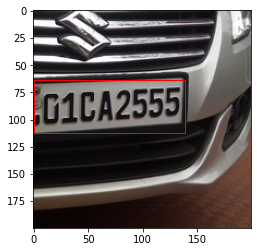

In [ ]:
fig, ax = plt.subplots()

image = list(train_images.take(10))[0]
label = list(train_labels.take(10))[0]

ax.imshow(image)
print(label)

dim = label[0]
rect = patches.Rectangle(tuple(dim[:2]), dim[2]-dim[0], dim[3]-dim[1], linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)

plt.show()

In [ ]:
# def load_data(x, l):
    # return np.expand_dims(x, 0), l


train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
# train = train.map(lambda x, l: tf.py_function(load_data, [x, l], [tf.float16, tf.float16]))
train = train.batch(32)


test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
# test = test.map(lambda x, l: tf.py_function(load_data, [x, l], [tf.float16, tf.float16]))
test = test.batch(32)


val = tf.data.Dataset.zip((valid_images, valid_labels))
val = val.shuffle(1000)
# val = val.map(lambda x, l: tf.py_function(load_data, [x, l], [tf.float16, tf.float16]))
val = val.batch(32)

In [59]:
vgg = VGG16(include_top=False)

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model():
    input_layer = Input(shape=(200, 200, 3))

    vgg = VGG16(include_top=False)(input_layer)

    vgg.trainable = False

    conv1 = Conv2D(512, (3, 3))(vgg)
    conv2 = Conv2D(256, (3, 3))(conv1)

    gmp = GlobalMaxPooling2D()(conv2)
    
    dense1 = Dense(1024, activation='relu')(gmp)
    dense2 = Dense(512, activation='relu')(dense1)
    dense3 = Dense(64, activation='relu')(dense2)
    dense4 = Dense(4, activation='relu')(dense3)

    model = Model(inputs=input_layer, outputs=dense4)
    return model
    

In [61]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         2359808   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         1179904   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 256)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

In [62]:
t = train.take(1).as_numpy_iterator().next()[0]
model.predict(t)


1/1 [==============================] - 4s 4s/step


array([[0.00324522, 0.        , 0.06888212, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00427657],
       [0.        , 0.        , 0.        , 0.21833047],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.09916485],
       [0.        , 0.        , 0.        , 0.05509321],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.09305279, 0.        ],
       [0.        , 0.08756608, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

def localization_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = y_pred[:,3] - y_pred[:,1] 
    w_pred = y_pred[:,2] - y_pred[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size
    

model.compile(optimizer=opt, loss=localization_loss)

hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
10/22 [============>.................] - ETA: 3:36 - loss: 663969.8750

KeyboardInterrupt: 

In [21]:
plt.plot(hist.history['val_loss'], label="val loss")
plt.plot(hist.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

NameError: name 'hist' is not defined

In [22]:
model.evaluate(test)

NameError: name 'test' is not defined

1/1 [==============================] - 0s 143ms/step


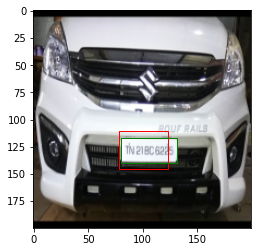

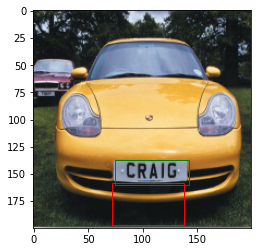

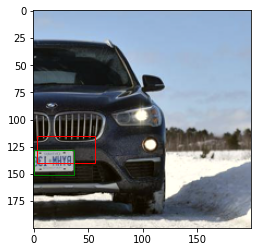

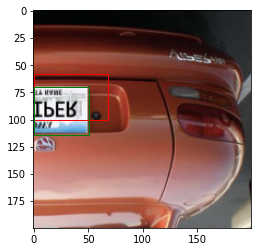

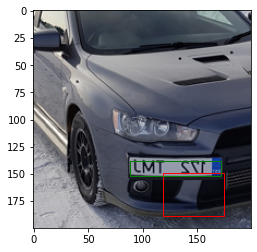

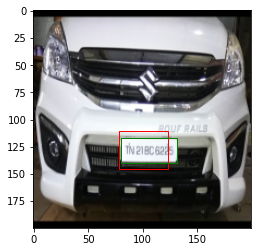

In [ ]:
test_im_lab = list(test.take(8))


columns = 4
rows = 3
for i in range(6):
    image = test_im_lab[i-1][0][0]
    real_label = test_im_lab[i-1][1][0].numpy()[0]
    pred_label = model.predict(np.expand_dims(image, 0))[0]

    image = image.numpy()

    fig, ax = plt.subplots()


    ax.imshow(np.array(image, dtype=np.float64))

    dim = pred_label
    rect = patches.Rectangle(tuple(dim[:2]), dim[2]-dim[0], dim[3]-dim[1], linewidth=1, edgecolor='r', facecolor='none')
    real_rect = patches.Rectangle(tuple(real_label[:2]), real_label[2]-real_label[0], real_label[3]-real_label[1], linewidth=1, edgecolor='g', facecolor='none')

    ax.add_patch(rect)
    ax.add_patch(real_rect)

    # area_pred = (dim[2]-dim[0])*(dim[3]-dim[1])
    # area_real = (real_label[2]-real_label[0])*(real_label[3]-real_label[1])



    # plt.title(f"{}%")
plt.show()

In [275]:
model.save('my_model1')

INFO:tensorflow:Assets written to: my_model1\assets


INFO:tensorflow:Assets written to: my_model1\assets
